🔥Exploration of Classier models for Deep Tennis Learning

The Methodology is the following : 
1- Get lags that make sense to give a pseudo temporal information of Before Bounce and After Bounce data

Iterate for several Classifier 
2- Explore a model
   Get best Params
   Get final score based on Precision ( limit a maximum the False Positif Rebounds
   Check the confusion Matrix ( to avoid too large False Negatif)
   Plot True Rebounds and False Rebounds for Visual Checking
   
3 Publish Results of all Clasifiers

### Libraries

1. Let's import the usual libraries:

In [115]:
from io import StringIO

import requests
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

DATA_URL = 'https://github.com/ArtLabss/tennis-tracking/raw/main/Bounces/BigDataFrame.csv'
resp = requests.get(DATA_URL)
df_ball = pd.read_csv(StringIO(resp.text))
print(df_ball.columns)
print(df_ball.shape)
df_ball.to_csv(r'/home/pguitteny/code/PhilippeGuitteny/final_tennis_exploration/BigDataFrame.csv', index=False, header=True)


Index(['x', 'y', 'V', 'bounce'], dtype='object')
(3674, 4)


Conclusion : X has no real link with bounce but can show a change of direction, so best to keep. Y is however very cyclic and change direction maybe 20 frames after a bounce. Difficult to measure the real impact of V. We can consider a lag model with +20 in the future, step1

In [116]:
def display_pred_test(y_pred_array,y_test,threshold) :
#Rationalize Prediction to 0 or 1 with a Threshold
    if (threshold!=0) :
        y_pred_proba=y_pred_array.copy()
        y_pred=pd.DataFrame(flat_values(y_pred_proba,threshold).astype(int))
    else :
        y_pred=pd.DataFrame(y_pred_array)
    print("#pred bounces",y_pred.sum()[0])#number of bounces
    y_test_resetindex=y_test.reset_index()
    y_test2=pd.DataFrame(y_test_resetindex['bounce'])
    print("#true bounces",y_test2.sum()[0]) #number of bounces
    
    my_list=[]
    for i in range(len(y_pred)):
        my_list.append(y_pred.iloc[i][0]-y_test2.iloc[i][0])

    my_diff_df=pd.DataFrame(my_list)
    
    
    fig = plt.figure()
    ax1 = fig.add_axes([0.1, 0.9, 0.8, 0.4],
                   xticklabels=[], ylim=(-0.1,0.5))
    ax2 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
                   xticklabels=[], ylim=(-0.1,1.1))
    ax3= fig.add_axes([0.1, 0.1, 0.8, 0.4],
                   ylim=(-1, 1))
    
    ax1.set_ylabel("Bounces predicted")
    ax1.plot(y_pred, color='r')
    
    ax2.set_ylabel("Real Bounces")
    ax2.plot(y_test2,color='b');
    
    ax3.set_ylabel("Diff")
    ax3.plot(my_diff_df,color='black');
    
    return y_pred

In [117]:
def flat_values(y_pred, threshold):
    for i in np.arange(np.size(y_pred)):
        if y_pred[i] < threshold:
            y_pred[i] = 0
        elif y_pred[i] > threshold: 
            y_pred[i] = 1
    return y_pred

In [118]:
def display_proba(y_pred_proba,y_test) :
#Rationalize Prediction to 0 or 1 with a Threshold
    MULTIPLY=5
    
    y_pred=pd.DataFrame(y_pred_proba)

    y_test_resetindex=y_test.reset_index()
    y_test2=pd.DataFrame(y_test_resetindex['bounce'])
    
    my_list=[]
    for i in range(len(y_pred)):
        my_list.append(MULTIPLY*y_pred.iloc[i][0]-y_test2.iloc[i][0])
    my_diff_df=pd.DataFrame(my_list)
    
    fig = plt.figure()
    ax1 = fig.add_axes([0.1, 0.9, 0.8, 0.4],
                   xticklabels=[], ylim=(-0.1,0.5))
    ax2 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
                   xticklabels=[], ylim=(-0.1,1.1))
    ax3= fig.add_axes([0.1, 0.1, 0.8, 0.4],
                   ylim=(-1, 1))
    
    ax1.set_ylabel("Bounces predicted")
    ax1.plot(y_pred, color='r')
    
    ax2.set_ylabel("Real Bounces")
    ax2.plot(y_test2,color='b');
    
    ax3.set_ylabel("Diff")
    ax3.plot(my_diff_df,color='black');

In [119]:
def final_display(y_pred,y_test,my_diff_df) :
    
    fig = plt.figure()
    ax1 = fig.add_axes([0.1, 0.9, 0.8, 0.4],
                   xticklabels=[], ylim=(-0.1,0.5))
    ax2 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
                   xticklabels=[], ylim=(-0.1,1.1))
    ax3= fig.add_axes([0.1, 0.1, 0.8, 0.4],
                   ylim=(-1, 1))
    
    ax1.set_ylabel("Bounces predicted")
    ax1.plot(y_pred, color='r')
    
    ax2.set_ylabel("Real Bounces")
    ax2.plot(y_test,color='b');
    
    ax3.set_ylabel("Diff")
    ax3.plot(my_diff_df,color='black')

In [120]:
def final_analysis(y_pred,y_test) :

    nb_pred_bounces=y_pred.sum()
    y_test_resetindex=y_test.reset_index()
    y_test2=pd.DataFrame(y_test_resetindex['bounce'])
    nb_true_bounces=y_test2.sum()[0]
    
    my_list=[];max_error=0; exact_match=0
    for i in range(len(y_pred)):
        if (y_pred[i]==1 and y_test2.iloc[i][0] ==1 ) :
            exact_match+=1
        diff=y_pred[i]-y_test2.iloc[i][0]
        max_error+=abs(diff)
        my_list.append(diff)
    my_diff_df=pd.DataFrame(my_list)
    
    print(f"True Bounces : {nb_true_bounces}, Predicted Bounces : {nb_pred_bounces}")
    print(f"Ratio of exact Predicted Bounces found: {round(abs(exact_match/nb_true_bounces)*100,0)}%")
    print(f"Average shift per false prediction :{round(max_error/(nb_true_bounces-exact_match),1)} frames shift")
    
    return my_diff_df


###  INVESTIGATAGE BEST LAGS 
with roc_auc_score and a Random Forest ( better model following pre-investigation than Linear Regression and KNN)


In [121]:
def lag_df(df_ball,lag):
    df = df_ball.drop(columns='bounce')
    df = df.shift(lag) - df
    df.rename(columns={'x':f'x_lagdelta:{lag}', 'y':f'y_lagdelta:{lag}', 'V':f'V_lagdelta:{lag}'}, inplace=True) 
    return df

In [122]:
def best_compromise_recall_precision(my_df) :
    #Find the best Recall value
    idx=my_df[['rec']].idxmax()
    best_recall=my_df['rec'][idx[0]]

    #Based on the best Recall value, find the best precision value

    list_prec=[];target={}
    for i in range(len(my_df. index)) :
        if my_df['rec'][i] == best_recall:
            target={'index':i,'recall' : my_df['rec'][i], 'precision' : my_df['prec'][i] }
            list_prec.append(target)
        
    my_df2=pd.DataFrame(list_prec)
    idx=my_df2[['precision']].idxmax()
    best_prec=my_df2['precision'][idx[0]]
    best_index=my_df2['index'][idx[0]]
    
    return best_index


In [123]:
def create_lag(df_ball,nb_lag,nb_steps,past_only,future_only) :

    my_table=[]
    if nb_steps==1 and past_only==1 and future_only==0  :
        start=-nb_lag
        stop=0
        for i in range(start,stop):
            my_table.append(i)  
            
    elif nb_steps==1 and past_only==0 and future_only==0 :
        start=-int(nb_lag/2)
        stop=int(nb_lag/2) + nb_lag%2
        for i in range(start,stop):
            my_table.append(i)
            
    elif nb_steps==1 and past_only==0 and future_only==1 :
        start=0
        stop=nb_lag
        for i in range(start,stop):
            my_table.append(i)   
            
#     elif nb_steps==2 and past_only==1 :
#         for i in range(nb_lag):
#             my_table.append(-2*(nb_lag+i))
            
#     elif nb_steps==2 and past_only==0 :
#         start=-int(nb_lag/2)
#         stop=int(nb_lag/2)
#         if (nb_lag%2==1) : 
#             stop+=1
#         for i in range(start,stop):
#             my_table.append(2*i)
        
    df_ball_lag = pd.concat([
         *(lag_df(df_ball,i) for i in my_table ),
         df_ball
     ], axis=1)   
    
    df_ball_lag = df_ball_lag.dropna()

    return df_ball_lag



In [66]:
STEPS=1
PAST_ONLY=0
FUTURE_ONLY=0
NB_LAGS=11
df_ball_lag = create_lag(df_ball,nb_lag=NB_LAGS,nb_steps=STEPS,past_only=PAST_ONLY,future_only=FUTURE_ONLY)
y = df_ball_lag.iloc[:, -1]
weight=int(round(len(y)/y.sum(),0))
weight

54

In [124]:
def create_train_split (df_ball_lag) :
    
    nb_test = 500
    X = df_ball_lag.iloc[:, :-1]
    X=X.drop(columns=['x','y','V'])
    y = df_ball_lag.iloc[:, -1]
    X_train = X.iloc[:-nb_test, :]
    y_train = y.iloc[:-nb_test] 
    X_test = X.iloc[-nb_test:, :]
    y_test = y.iloc[-nb_test:]
    return X_train,y_train,X_test,y_test




In [125]:
def fit_model(model1,X_train,y_train,X_test):
 
    model = make_pipeline(StandardScaler(),model1)
    model.fit(X_train, y_train)
    return model

In [126]:
def evaluate_score(my_roc_auc_score_pastonly_dict) : 
    max_val = max(my_roc_auc_score_pastonly_dict.values())
    max_keys = [k for k, v in my_roc_auc_score_pastonly_dict.items() if v == max_val]
    print(f"Best ROC score is {max_val} found for the lags : {max_keys}")

In [127]:
def confusion_matrix_params(y_test,weighted_prediction):
    acc=round(accuracy_score(y_test, weighted_prediction),2)
    rec=round(recall_score(y_test, weighted_prediction),3)
    prec=round(precision_score(y_test, weighted_prediction,zero_division=1),3)
    F1=round(f1_score(y_test, weighted_prediction),2)
    if ( rec >=0.8) :
        print(f"accuracy_score {acc}, recall_score {rec}, precision_score {prec} ")
        print(confusion_matrix(y_test, weighted_prediction))
    return   acc,rec,prec,F1

### test lag with Future values After Rebound values

In [128]:
global_list=[]
local_list={}

model=RandomForestClassifier(n_estimators=500, n_jobs=-1)
X_train,y_train,X_test,y_test = create_train_split(df_ball_lag)
model_fitted = fit_model(model,X_train,y_train,X_test)
y_test_pred_proba=model_fitted.predict_proba(X_test)[:,1]

roc = pd.DataFrame(dict(zip(['false_positive_rate', 'true_positive_rate', 'thresholds'], roc_curve(y_test, y_test_pred_proba))))
score=roc_auc_score(y_test, y_test_pred_proba)
print("ROC SCORE",round(score,2))

y_pred = model_fitted.predict(X_test)
print(confusion_matrix(y_test, y_pred))



ROC SCORE 0.94
[[488   0]
 [ 12   0]]


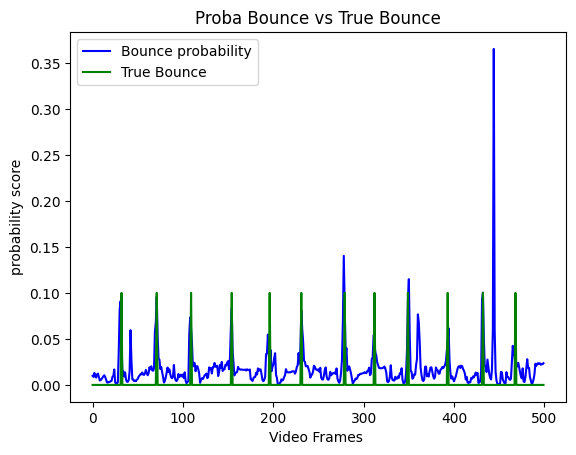

pred    0    1
true          
0     352  136
1       1   11


In [160]:
# Threshold defined based on experiments 
thres=0.85
eps = roc[roc['true_positive_rate']>thres]['thresholds'].iloc[0]

y_test_pred = (y_test_pred_proba >= eps).astype('int')
plt.title("Proba Bounce vs True Bounce")
plt.plot(y_test_pred_proba, "-b", label="Bounce probability")

y_test_resetindex=y_test.reset_index()
y_test2=pd.DataFrame(y_test_resetindex['bounce'])/10
# plt.plot(y_test2, color='green')
plt.plot(y_test2, "-g", label="True Bounce")
plt.legend(loc="upper left")
plt.xlabel("Video Frames ")
plt.ylabel("probability score")
plt.show()

print(pd.crosstab(pd.Series(y_test.values, name='true'), pd.Series(y_test_pred, name='pred')))

True Bounces : 12, Predicted Bounces : 72
Ratio of exact Predicted Bounces found: 92.0%
Average shift per false prediction :62.0 frames shift


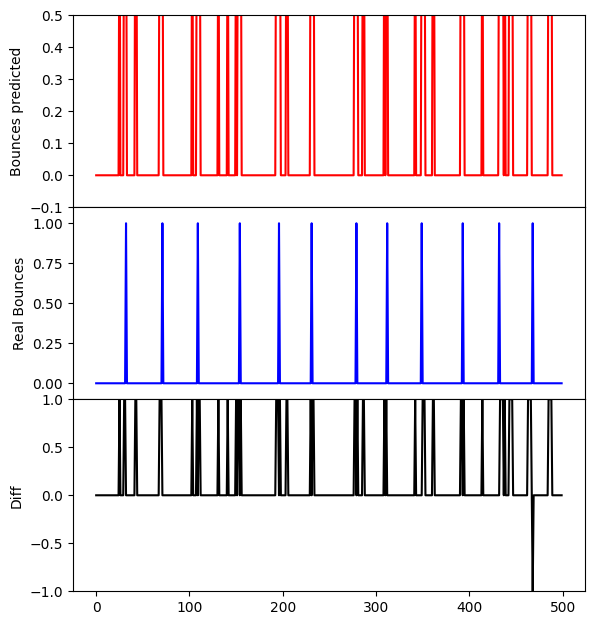

In [130]:
diff_df=final_analysis(y_test_pred,y_test)
final_display(y_test_pred,y_test,diff_df)

In [134]:
#cleanup the next NB_ITER frames to eliminate False Bounces - this is a window to keep the best Proba
NB_ITER=25

In [135]:
def prediction_bounce(prediction_list):

    final_round=0
    for j in range(len(prediction_list)):
        if prediction_list[j]==1 and final_round==0:
            #create window of proba
            nb_iter=NB_ITER
            if (j+NB_ITER) > len(prediction_list):
                nb_iter=len(prediction_list)-j
                final_round=1

            my_list=y_test_pred_proba[j:j+nb_iter]
            index_max=my_list.argmax()

            prediction_list[j+index_max]=1
            for k in range(0,index_max) :
                prediction_list[j+k]=0
            for k in range(index_max+1,nb_iter) :
                prediction_list[j+k]=0

    return prediction_list

True Bounces : 12, Predicted Bounces : 12
Ratio of exact Predicted Bounces found: 33.0%
Average shift per false prediction :2.0 frames shift


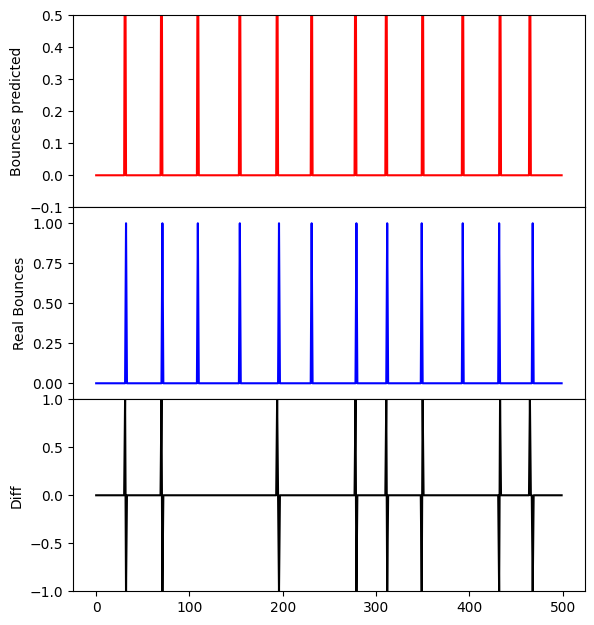

In [136]:
yprediction=prediction_bounce(y_test_pred)
diff_df=final_analysis(yprediction,y_test)
final_display(yprediction,y_test,diff_df)

### XGBOOST Classifier investigation

In [162]:
model = xgb.XGBClassifier(objective="binary:logistic", colsample_bytree=0.3, random_state=42,base_score=0.5, booster='gbtree'\
                          , gamma=0.3, learning_rate=0.04,\
                            max_delta_step=0, max_depth=2, subsample = 0.4,\
                            n_estimators=100, n_jobs=1, verbosity=1)
    
X_train,y_train,X_test,y_test = create_train_split(df_ball_lag)
model_fitted = fit_model(model,X_train,y_train,X_test)
y_test_pred_proba=model_fitted.predict_proba(X_test)[:,1]
roc = pd.DataFrame(dict(zip(['false_positive_rate', 'true_positive_rate', 'thresholds'], roc_curve(y_test, y_test_pred_proba))))
score=roc_auc_score(y_test, y_test_pred_proba)
print("ROC SCORE",round(score,2))

y_pred = model_fitted.predict(X_test)
print(confusion_matrix(y_test, y_pred))




ROC SCORE 0.92
[[488   0]
 [ 12   0]]


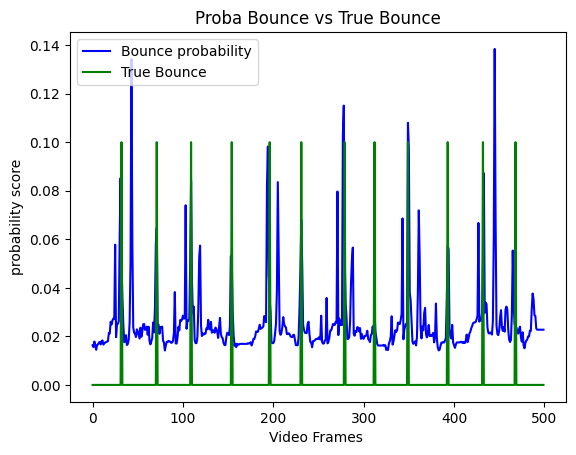

pred    0   1
true         
0     424  64
1       1  11


In [163]:
# Threshold defined based on experiments 
thres=0.85
eps = roc[roc['true_positive_rate']>thres]['thresholds'].iloc[0]

y_test_pred = (y_test_pred_proba >= eps).astype('int')
plt.title("Proba Bounce vs True Bounce")
plt.plot(y_test_pred_proba, "-b", label="Bounce probability")

y_test_resetindex=y_test.reset_index()
y_test2=pd.DataFrame(y_test_resetindex['bounce'])/10
# plt.plot(y_test2, color='green')
plt.plot(y_test2, "-g", label="True Bounce")
plt.legend(loc="upper left")
plt.xlabel("Video Frames ")
plt.ylabel("probability score")
plt.show()

print(pd.crosstab(pd.Series(y_test.values, name='true'), pd.Series(y_test_pred, name='pred')))

True Bounces : 12, Predicted Bounces : 75
Ratio of exact Predicted Bounces found: 92.0%
Average shift per false prediction :65.0 frames shift


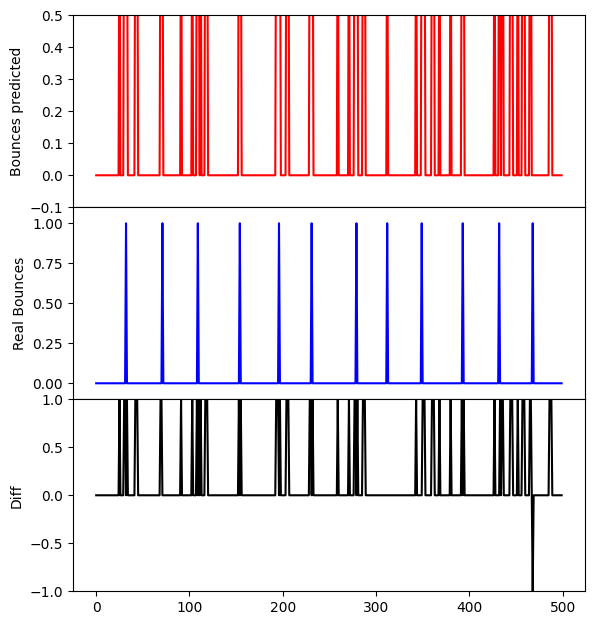

In [139]:
diff_df=final_analysis(y_test_pred,y_test)
final_display(y_test_pred,y_test,diff_df)

True Bounces : 12, Predicted Bounces : 12
Ratio of exact Predicted Bounces found: 50.0%
Average shift per false prediction :2.0 frames shift


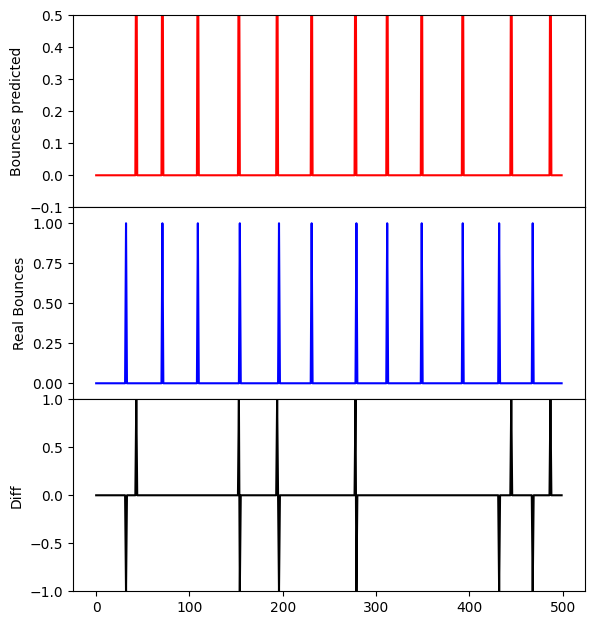

In [140]:
yprediction=prediction_bounce(y_test_pred)
diff_df=final_analysis(yprediction,y_test)
final_display(yprediction,y_test,diff_df)

Conclusion : Half CONVINCING -> Visually bad and lots of false Positive

### PLaying with SVC parameters 

In [184]:
kernel="rbf"
C=2.0
gamma="scale"

model = SVC(kernel=kernel, gamma=gamma, probability = True, random_state=42, C=C,class_weight={0:1,1: weight})

X_train,y_train,X_test,y_test = create_train_split(df_ball_lag)
model_fitted = fit_model(model,X_train,y_train,X_test)
y_test_pred_proba=model_fitted.predict_proba(X_test)[:,1]

roc = pd.DataFrame(dict(zip(['false_positive_rate', 'true_positive_rate', 'thresholds'], roc_curve(y_test, y_test_pred_proba))))
score=roc_auc_score(y_test, y_test_pred_proba)
print("ROC SCORE",round(score,2))

y_pred = model_fitted.predict(X_test)
print(confusion_matrix(y_test, y_pred))



ROC SCORE 0.93
[[455  33]
 [  2  10]]


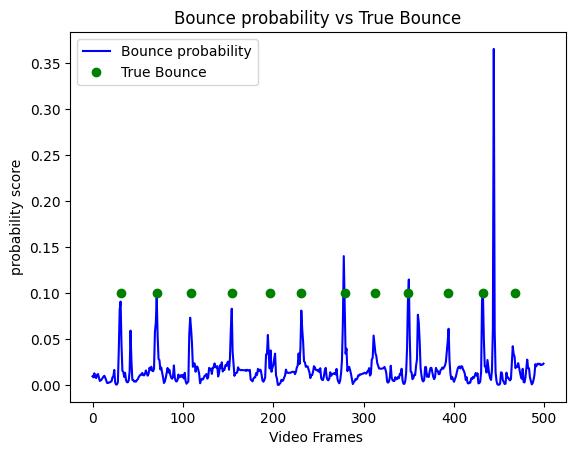

pred    0    1
true          
0     352  136
1       1   11


In [199]:
# Threshold defined based on experiments 
thres=0.85
eps = roc[roc['true_positive_rate']>thres]['thresholds'].iloc[0]

y_test_pred = (y_test_pred_proba >= eps).astype('int')
plt.title("Bounce probability vs True Bounce")
plt.plot(y_test_pred_proba, "-b", label="Bounce probability")

y_test_resetindex=y_test.reset_index()
y_test_df=pd.DataFrame(y_test_resetindex)
y_test_df1=y_test_df[y_test_df["bounce"] == 1]/10
plt.plot(y_test_df1['bounce'], "og", label="True Bounce")
plt.legend(loc="upper left")
plt.xlabel("Video Frames ")
plt.ylabel("probability score")
plt.show()

print(pd.crosstab(pd.Series(y_test.values, name='true'), pd.Series(y_test_pred, name='pred')))

True Bounces : 12, Predicted Bounces : 147
Ratio of exact Predicted Bounces found: 92.0%
Average shift per false prediction :137.0 frames shift


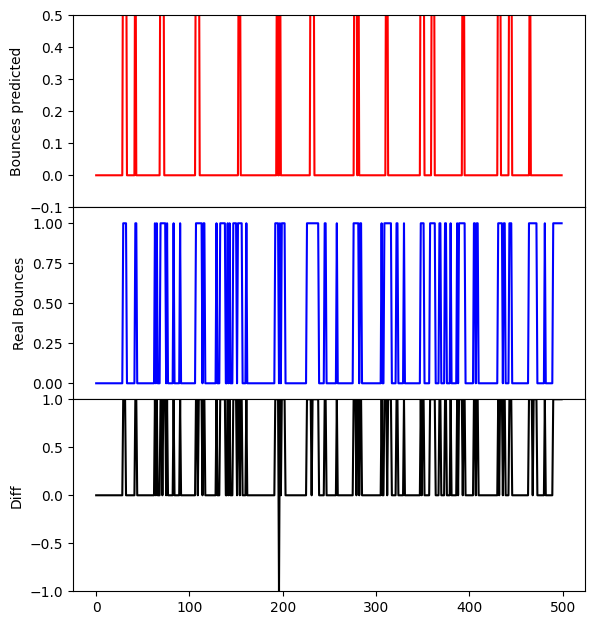

In [143]:
diff_df=final_analysis(y_test_pred,y_test)
final_display(y_pred,y_test_pred,diff_df)


True Bounces : 12, Predicted Bounces : 12
Ratio of exact Predicted Bounces found: 25.0%
Average shift per false prediction :2.0 frames shift


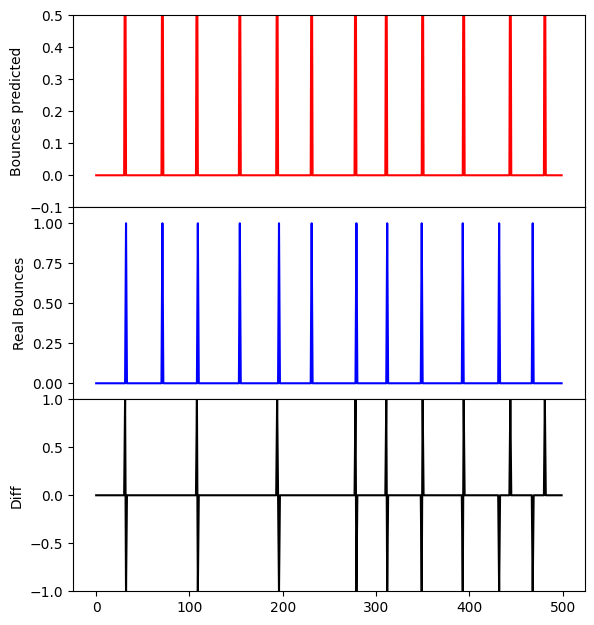

In [144]:
yprediction=prediction_bounce(y_test_pred)
diff_df=final_analysis(yprediction,y_test)
final_display(yprediction,y_test,diff_df)

### PLaying with SGDClassifier parameters 

In [145]:
# loss="modified_huber"
# penalty="l1"
# alpha=0.01
# max_iter=5
# l1_ratio=0.05
# epsilon=0.0

loss="huber"
penalty="elasticnet"
alpha=0.0001
max_iter=100
l1_ratio=0.15
epsilon=0.3

model = SGDClassifier(loss=loss,penalty=penalty,l1_ratio=l1_ratio,epsilon=epsilon,shuffle=False, \
                                               max_iter=max_iter,alpha=alpha,class_weight={0:1,1: weight})

    
X_train,y_train,X_test,y_test = create_train_split(df_ball_lag)
model_fitted = fit_model(model,X_train,y_train,X_test)

y_pred = model_fitted.predict(X_test)
print(confusion_matrix(y_test, y_pred))




[[179 309]
 [  4   8]]


True Bounces : 12, Predicted Bounces : 317
Ratio of exact Predicted Bounces found: 67.0%
Average shift per false prediction :78.2 frames shift


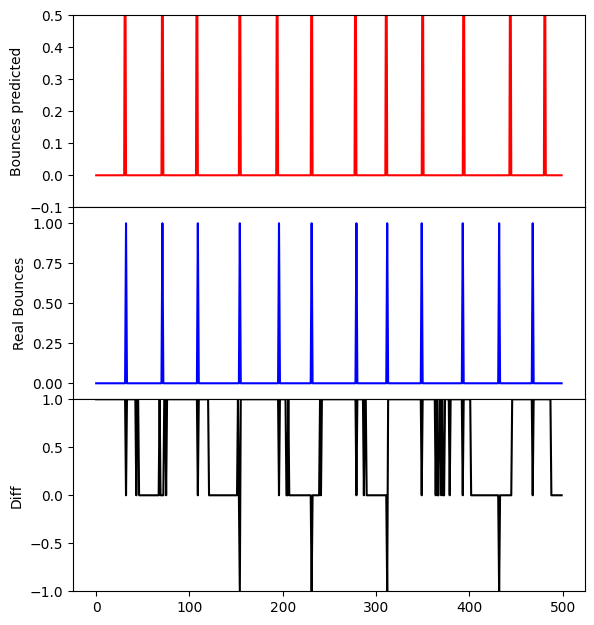

In [146]:
diff_df=final_analysis(y_pred,y_test)
final_display(y_test_pred,y_test,diff_df)

True Bounces : 12, Predicted Bounces : 12
Ratio of exact Predicted Bounces found: 25.0%
Average shift per false prediction :2.0 frames shift


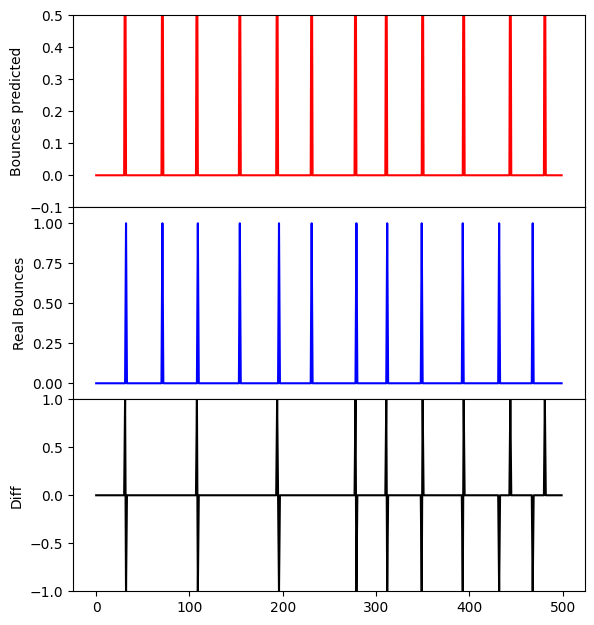

In [147]:
yprediction=prediction_bounce(y_test_pred)
diff_df=final_analysis(yprediction,y_test)
final_display(yprediction,y_test,diff_df)

### SDGC can  be forgotten, SGDC is going too many false postive

CONCLUSION WE CERTAINLY FOUND ALL BOUNCES BUT WE SO MANY FALSE POSITIVE IT IS USELESS. PRECISION WOULD NEED TO BE AT LEAST 80% to FILTER FALSE POSITIVE